# Proyecto No. 3 -  Modelos Avanzados de Análisis de Datos 


### Integrantes:
- Denis Leonardo Jaimes Campos | Código: 202027884.
- Esteban López Zúñiga | Código: 200914313.
- Oscar Hernando Ayala Nino | Código: 201920024.
- Sebastián Camilo Camargo Bello | Código: 201014774.
- Sindy Lorena Murcia Florez | Código: 202028060.






# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="https://github.com/dljaimes/AdvancedMethodsinDataAnalysis1Grupo_5/blob/main/moviegenre.png?raw=1"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4201-202019-p3-moviegenreclassification/overview

### Data

Input:
- movie plot

Output:
- Probability of the movie belonging to each genre


### Evaluation

- 50% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 50% Performance in the Kaggle competition (The grade for each group will be proportional to the ranking it occupies in the competition. The group in the first place will obtain 5 points, for each position below, 0.25 points will be subtracted, that is: first place: 5 points, second: 4.75 points, third place: 4.50 points ... eleventh place: 2.50 points, twelfth place: 2.25 points).


### Deadline
- The project must be carried out in the groups assigned.
- Use clear and rigorous procedures.
- The delivery of the project is on August 1st, 2021, 11:59 pm, through Bloque Neón.
- No projects will be received after the delivery time or by any other means than the one established. 




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

# CONTENIDO:


- 0. Cargue de los datos.
- 1. Análisis Variable de repuesta.
- 2. Limpieza y procesamiento.
- 3. Modelamiento.
- 4. Resultados Finales.

Instalación de librerías requeridas para el desarrollo del proyecto:

In [ ]:
!pip install -q wordcloud
!pip install livelossplot==0.1.2

  Created wheel for livelossplot: filename=livelossplot-0.1.2-py3-none-any.whl size=3829 sha256=4dcca048962a815d9ef3091ca40691535452494bc743cc52e8b59f49ba8dee36
  Stored in directory: /root/.cache/pip/wheels/d8/78/c7/7d1e3952810ddf926b4d4dbf536a52e7b6821bd54b6f6a84a8
Successfully built livelossplot


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split,GridSearchCV


from keras.models import Sequential
from keras.layers import Flatten
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from livelossplot import PlotLossesKeras

import keras
from keras import backend as K
from sklearn.model_selection import train_test_split
import re
import nltk

from nltk.corpus import stopwords
from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Se descargan los Stopwords:
nltk.download('stopwords')
nltk.corpus.stopwords.words('english')
nltk.download('wordnet');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 0. CARGUE DE LOS DATOS

In [ ]:
# Se cargan las bases de entrenamiento y de Prueba:

dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [ ]:
print('Training: \n',dataTraining.head(2))
print('----'*30)
print('----'*30)
print('Testing: \n',dataTesting.head(2))

Training: 
       year                      title  ...                         genres rating
3107  2003                       Most  ...             ['Short', 'Drama']    8.0
900   2008  How to Be a Serial Killer  ...  ['Comedy', 'Crime', 'Horror']    5.6

[2 rows x 5 columns]
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Testing: 
    year                title                                               plot
1  1999  Message in a Bottle  who meets by fate ,  shall be sealed by fate ....
4  1978     Midnight Express  the true story of billy hayes ,  an american c...


Se observa que la base consta de 7.895 registros y de 5 variables (año de la película, título, descripción (plot), género(s) y calificación). Al poder tener más de un género por película, se trata de un problema de clasificación 'Multilabel', para ello es necesario separar cada uno de los posibles géneros con sus respectivas columnas y poder entrenar en conjunto, un modelo capáz de usar el texto de la descripción de la película (plot) para predecir la probabilidad de que pertenezca a cada género.

# 1. ANÁLISIS VARIABLE DE SALIDA

In [ ]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x)) 

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

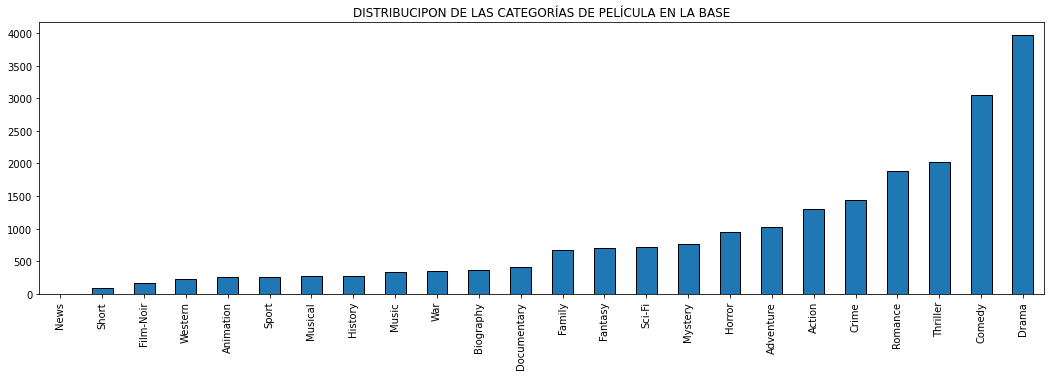

In [ ]:
pd.DataFrame(y_genres, columns=le.classes_).sum().sort_values().plot(kind='bar', figsize=(18,5), grid=False, ec='black', title='DISTRIBUCIPON DE LAS CATEGORÍAS DE PELÍCULA EN LA BASE');

Se observa como las categorías de Drama, Comedy, Thriller y Romance, son las que mayor participación tienen. Así mismo, las categorías de News, Short y Film-Noir presentan la menor frecuencia.

# 2. LIMPIEZA Y PREPROCESAMIENTO DEL TEXTO

Previo a la implementación de cualquier modelo de Machine Learning, se requiere hacer una 'limpieza' sobre los datos:

En esta etapa se busca eliminar los caractéres especiales así como las palabras que no agregan 'valor' al texto (stop words), todo esto con el fin de reducir el corpus (texto completo) a usar en el modelo.

In [ ]:
import re
import nltk
nltk.corpus.stopwords.words('english')
nltk.download('wordnet') 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer # Stemming
from nltk.stem import WordNetLemmatizer # lemmatizacion

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Se eliminan caracteres especiales:


def pre_process(text):
    # lowercase
    text = text.lower()
    # tags
    text = re.sub('&lt;/?.*?&gt;',' &lt;&gt; ',text)
    # special characters and digits
    text=re.sub('(\\d|\\W)+',' ',text)
    # remove punctuation
    #text = re.sub('[.;:!\'?,\"()\[\]]', '', text)
    #text = [REPLACE.sub('', line) for line in text]
    
    return text

dataTraining['plot_low']=dataTraining['plot'].apply(lambda x:pre_process(x))
dataTesting['plot_low']=dataTesting['plot'].apply(lambda x:pre_process(x))



###############################################################################

# se eliminan stopwords

english_stop_words=stopwords.words('english')

def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

dataTraining['plot_low_rm'] = remove_stop_words(dataTraining['plot_low'])
dataTesting['plot_low_rm'] = remove_stop_words(dataTesting['plot_low'])

###############################################################################

# Stemming:


def get_stemmed_text(corpus):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

dataTraining['plot_low_rm_stem'] = get_stemmed_text(dataTraining['plot_low_rm'])
dataTesting['plot_low_rm_stem'] = get_stemmed_text(dataTesting['plot_low_rm'])

###############################################################################

# LEMATIZACION:


def lemma(texto):
  lemmatizador = WordNetLemmatizer()
  return [' '.join([lemmatizador.lemmatize(word) for word in review.split()]) for review in texto]

dataTraining['plot_low_rm_lemma'] = lemma(dataTraining['plot_low_rm'])
dataTesting['plot_low_rm_lemma'] = lemma(dataTesting['plot_low_rm'])


In [ ]:
# Visualización de los ajustes en el texto:

dataTraining.head(2)

,year,title,plot,genres,rating,plot_low,plot_low_rm,plot_low_rm_stem,plot_low_rm_lemma
3107,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0,most is the story of a single father who takes...,story single father takes eight year old son w...,stori singl father take eight year old son wor...,story single father take eight year old son wo...
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6,a serial killer decides to teach the secrets o...,serial killer decides teach secrets satisfying...,serial killer decid teach secret satisfi caree...,serial killer decides teach secret satisfying ...


Se observa como quedan en el dataframe las columnas con las respectivas depuraciones realizadas al texto.

# 2. TOKENIZACIÓN 

Una vez depurado el texto de cada reseña (plot), se realiza el proceso de Tokenización para poder separar las palabras del texto y con esto, poder hacer la transformación del texto a un formato numérico, el cual es el que se usaría en la implementación de modelos.

Para este caso, se evalúan tres opciones para hacer dicha transformación:

- Countvectorizer(): Crea una matriz con cada palabra que se encuentre en el texto, donde cada columna corresponde a la palabra identificada y cada fila al registro del dataframe (7.895 registros).

- TfidfVectorizer(): Realiza lo mismo que el anterior pero en vez de asignar valores enteros en la matriz creo porcentajes de participaci´no de cada palabra dentro del documento.

- Tokenizer de Keras: Crea un diccionario de la spalabras más recurrentes, en este aparece cada palabra con su respectivo índice.

## 2.1 USANDO: COUNT VECTORIZER()


In [ ]:
# Usando el countvectorizer de scikit learn:

vect = CountVectorizer(max_features=3000, min_df=0.0005)
X_dtm = vect.fit_transform(dataTraining['plot_low_rm_stem'])
voca_coun_vec = vect.vocabulary_ # vocabulario de countvectorizer()

print(X_dtm.shape)

(7895, 3000)


In [ ]:
print(voca_coun_vec)

{'stori': 4274, 'singl': 4077, 'father': 1645, 'take': 4412, 'eight': 1415, 'year': 4980, 'old': 3141, 'son': 4160, 'work': 4949, 'railroad': 3583, 'bridg': 550, 'day': 1118, 'boy': 520, 'meet': 2826, 'woman': 4941, 'board': 483, 'train': 4590, 'drug': 1349, 'abus': 16, 'goe': 1897, 'engin': 1482, 'room': 3827, 'tell': 4451, 'stay': 4249, 'edg': 1400, 'nearbi': 3019, 'lake': 2521, 'ship': 4029, 'come': 877, 'lift': 2611, 'though': 4505, 'suppos': 4362, 'arriv': 242, 'hour': 2157, 'later': 2537, 'happen': 2004, 'see': 3948, 'tri': 4614, 'warn': 4850, 'abl': 8, 'approach': 214, 'fall': 1620, 'gear': 1855, 'attempt': 279, 'lower': 2679, 'leav': 2566, 'horrif': 2147, 'choic': 757, 'crush': 1061, 'peopl': 3288, 'complet': 905, 'fact': 1609, 'die': 1227, 'save': 3903, 'addict': 48, 'look': 2655, 'window': 4922, 'movi': 2967, 'end': 1474, 'man': 2730, 'wander': 4841, 'new': 3051, 'citi': 781, 'longer': 2653, 'hold': 2114, 'small': 4117, 'babi': 316, 'run': 3851, 'parallel': 3228, 'name': 2996

## 2.2. USANDO KERAS TOKENIZER()

In [ ]:
tok_keras = Tokenizer(num_words=5000, oov_token='oov')
tok_keras.fit_on_texts(dataTraining['plot_low_rm_stem'])
vocab_keras = tok_keras.word_index

In [ ]:
print(vocab_keras)

{'oov': 1, 'n': 2, 'one': 3, 'get': 4, 'find': 5, 'life': 6, 'new': 7, 'friend': 8, 'year': 9, 'live': 10, 'love': 11, 'man': 12, 'take': 13, 'make': 14, 'two': 15, 'want': 16, 'famili': 17, 'work': 18, 'tri': 19, 'time': 20, 'becom': 21, 'go': 22, 'father': 23, 'meet': 24, 'kill': 25, 'young': 26, 'come': 27, 'help': 28, 'also': 29, 'day': 30, 'decid': 31, 'old': 32, 'world': 33, 'back': 34, 'way': 35, 'name': 36, 'wife': 37, 'see': 38, 'home': 39, 'stori': 40, 'mother': 41, 'tell': 42, 'learn': 43, 'school': 44, 'believ': 45, 'son': 46, 'howev': 47, 'hous': 48, 'murder': 49, 'know': 50, 'woman': 51, 'like': 52, 'daughter': 53, 'turn': 54, 'first': 55, 'girl': 56, 'town': 57, 'use': 58, 'begin': 59, 'marri': 60, 'soon': 61, 'end': 62, 'discov': 63, 'fall': 64, 'peopl': 65, 'even': 66, 'brother': 67, 'plan': 68, 'may': 69, 'film': 70, 'job': 71, 'call': 72, 'leav': 73, 'return': 74, 'citi': 75, 'money': 76, 'york': 77, 'goe': 78, 'start': 79, 'three': 80, 'set': 81, 'run': 82, 'boy': 8

In [ ]:
vocab_keras['singl']

630

In [ ]:
# Se transforma cada texto en palabras de acuerdo con su diccionario de índices:

frases_num = tok_keras.texts_to_sequences(dataTraining['plot_low_rm_stem'])
matriz_pad =  pad_sequences(frases_num, padding='post')

In [ ]:
matriz_pad[1][:20]

array([1020,  201,   31,  553,  125, 3074,  272, 1101,  491, 1647,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

## 2.3 Usando TfidfVectorizer

In [ ]:
tf_vec = TfidfVectorizer(max_features=6000)
X_tf = tf_vec.fit_transform(dataTraining['plot_low_rm_stem'])

In [ ]:
# Tranformación para la base de Testing:
f_test = tf_vec.transform(dataTesting['plot_low_rm_stem'])

# ------------------------------------------------------------------------------------------------------------

# 3. MODELAMIENTO

Ya con los textos transformados en números (paso anterior) se procede a hacer la partición de Train y test para evaluar cada uno de los posibles modelos a implementar.

Ya que la matriz de variables regresoras (texto transformado en número) tiene 6 mil registros (máximo de palbras), se prevee que el entrenamiento de los modelos puede consumir bastantes recursos computacionales.

## 3.1 PARTICIONN DATOS DE TRAIN Y TEST

In [ ]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm.todense(), y_genres, test_size=0.33, random_state=42)
#X_train, X_test, y_train_genres, y_test_genres = train_test_split(matriz_pad, y_genres, test_size=0.33, random_state=42)

### Train multi-class multi-label model

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

#### MODELO GAUSIANO NB

In [ ]:
modelo_nb = GaussianNB()

In [ ]:
# Usando Naive Bayes:
nb_c = OneVsRestClassifier(GaussianNB())
#gbc = OneVsRestClassifier(GradientBoostingClassifier(max_depth=10,n_estimators=150,max_features=))

In [ ]:
%%time

# Entrenamiento modelo Naive Bayes:

nb_c.fit(X_train, y_train_genres)

CPU times: user 4.03 s, sys: 84.5 ms, total: 4.11 s
Wall time: 4.13 s


OneVsRestClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                    n_jobs=None)

In [ ]:
# Predicciones modelo Naive Bayes

pred_gbc = nb_c.predict_proba(X_test)
roc_auc_score(y_test_genres, pred_gbc, average='macro')

0.6125208260515932

In [ ]:
pd.DataFrame(pred_gbc).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,4.819194e-298,2.119403e-213,0.0,0.0,9.858238e-304,1.000000e+00,0.0,1.096861e-41,1.0,1.000000e+00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.044654e-147,1.0,0.0,0.0,1.370927e-169,0.0,0.0
1,1.000000e+00,1.000000e+00,0.0,1.0,9.626467e-46,1.229492e-34,0.0,4.306376e-43,1.0,1.000000e+00,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.000000e+00,1.0,0.0,0.0,2.348930e-39,0.0,0.0
2,1.000000e+00,1.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1.725724e-71,0.0,1.771723e-286,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000e+00,1.0,0.0,0.0,1.000000e+00,0.0,0.0


Se observa como el modelo da como salida una matriz de 24 columnas (una por cada categoría) en la que se registran las probabilidades de que cada película (fila) pertenezca a dicha categoría.

In [ ]:
pred_nb = nb_c.predict_proba(X_test)
roc_auc_score(y_test_genres, pred_nb, average='macro')

0.6505733721375314

El modelo arroja como resultado un AUC de 0.65 para los datos de test (datos que nuevos para el modelo).

# XGBOOST

Debido a la cantidad de columnas de la matriz de entrada (X), se optó por hacer el Tune-In de este modelo de manera manual, para ello, se corría el modelo con ciertos hiperparámetros predeterminados, calculando el AUC y luego se volviendo a correr el modelo cambiando los hiperparámetros  (básicamente, una validación manual de lo que realiza una grilla).

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = OneVsRestClassifier(XGBClassifier(random_state=42,n_estimators=200, learning_rate=0.3, max_depth=7))
xgb.fit(X_train, y_train_genres)

In [ ]:
y_pred_genresxg = xgb.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genresxg, average='macro')

0.8354213500350042

In [ ]:
####################### resultados usando COUNTVETORIZER() y Lemma:
-------- Para un número de palabras = 5 mil

learning rate =0.1, n_jobs=1, n_estimators=100, max_depth=3, random_state=42  : 0.8391366613062118
learning rate =0.1, n_jobs=1, n_estimators=200, max_depth=3, random_state=42  : 0.8379697098500808
learning rate =0.3, n_jobs=1, n_estimators=100, max_depth=5, random_state=42  : 0.8434843032865246
learning rate =0.3, n_jobs=1, n_estimators=200, max_depth=5, random_state=42  : 0.8434843032865246
learning rate =0.3, n_jobs=1, n_estimators=100, max_depth=7, random_state=42  : 0.8403513018075838
learning rate =0.3, n_jobs=1, n_estimators=100, max_depth=3, random_state=42  : 0.8418200586529831
learning rate =0.3, n_jobs=1, n_estimators=200, max_depth=3, random_state=42  : 0.8379697098500808
learning rate =0.5, n_jobs=1, n_estimators=100, max_depth=3, random_state=42  : 0.834508059445182
learning rate =0.5, n_jobs=1, n_estimators=200, max_depth=3, random_state=42  : 0.8334327736298276

-------- Para un número de palabras =  3mil
learning rate =0.1, n_jobs=1, n_estimators=100, max_depth=3, random_state=42  : 0.8278829167399256
learning rate =0.1, n_jobs=1, n_estimators=200, max_depth=3, random_state=42  : 0.8371912538301466
learning rate =0.3, n_jobs=1, n_estimators=500, max_depth=3, random_state=42  : 0.8232835712614154
learning rate =0.1, n_jobs=1, n_estimators=200, max_depth=5, random_state=42  : 0.8354213500350042


SyntaxError: ignored

 El mejor modelo se obtiene con el valor de AUC de 0.8434
 
 learning rate =0.3, n_jobs=1, n_estimators=200, max_depth=5, random_state=42

In [ ]:
X_test_dtm = vect.transform(dataTesting['plot_low_rm_stem'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = xgb.predict_proba(X_test_dtm)

# GradientBoostingClassifier


Al igual que el XGBoost, el Tune In se realiza de manera manual ya que al intentar hacerlo por grilla, se consume bastantes recursos computacionales (muchísimo tiempo para calibrar).

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = OneVsRestClassifier(GradientBoostingClassifier(random_state=42,n_estimators=200))
gb.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=

In [ ]:
y_pred_genresgb = gb.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genresgb, average='macro')

0.7919201382227256

In [ ]:
####################### resultados usando COUNTVETORIZER() y Lemma:
-------- Para un número de palabras = 3 mil

learning rate =0.1, n_jobs=1, n_estimators=100, max_depth=3, random_state=42  : 0.791546841465498
learning rate =0.1, n_jobs=1, n_estimators=200, max_depth=3, random_state=42  : 0.7919201382227256
learning rate =0.1, n_jobs=1, n_estimators=200, max_depth=5, random_state=42  : 0.7945468422746468

-------- Para un número de palabras = 5 mil

learning rate =0.1, n_jobs=1, n_estimators=200, max_depth=3, random_state=42  : 0.7946901445030538
learning rate =0.1, n_jobs=1, n_estimators=200, max_depth=5, random_state=42  : 0.8045030538546875

In [ ]:
X_test_dtm = vect.transform(dataTesting['plot_low_rm_stem'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = gb.predict_proba(X_test_dtm)

No se observa un valor que mejor el XGboost

## RANDOM FOREST

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=5, random_state=42))

In [ ]:
%%time

clf.fit(X_train, y_train_genres);

CPU times: user 19.2 s, sys: 1.1 s, total: 20.3 s
Wall time: 2min 41s


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=5,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                               

In [ ]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8094906641418312

In [ ]:
####################### resultados usando COUNTVETORIZER() y Lemma:

"""
------- Para un número de palabras = 1 mil

n_jobs=-1, n_estimators=200, max_depth=7, random_state=42 : 0.7872131570577036
n_jobs=-1, n_estimators=200, max_depth=10, random_state=42 : 0.7840666999257996
n_jobs=-1, n_estimators=250, max_depth=7, random_state=42 : 0.7901943042466396
n_jobs=-1, n_estimators=250, max_depth=7, random_state=42 : 0.7908025199296361
n_jobs=-1, n_estimators=500, max_depth=7, random_state=42 : 0.7931854788836633
n_jobs=-1, n_estimators=500, max_depth=5, random_state=42 : 0.7934482357988548
n_jobs=-1, n_estimators=700, max_depth=3, random_state=42 : 0.7926350713330667
n_jobs=-1, n_estimators=500, max_depth=3, random_state=42 : 0.7918581885906483
n_jobs=-1, n_estimators=500, max_depth=4, random_state=42 : 0.7916051690107286


------- Para un número de palabras = 3 mil

n_jobs=-1, n_estimators=500, max_depth=5, random_state=42 : 0.8105434607387648
-------- Para un número de palabras = 5 mil

n_jobs=-1, n_estimators=500, max_depth=5, random_state=42  : 0.8203351605539488

"""
################## resultados usando COUNTVETORIZER() y Stemm:
"""
-------- Para un número de palabras = 5 mil

n_jobs=-1, n_estimators=500, max_depth=5, random_state=42  : 0.8238489387536768
"""
################## resultados usando COUNTVETORIZER(ngram_range=range(1,2)) y Stemm:

"""

n_jobs=-1, n_estimators=500, max_depth=5, random_state=42  : 0.8204102576175692

"""
########### resultados countvetorizer(min_df=0.2,max_features=5000 ) y stemma:

"""
"""

In [ ]:
X_dtm_test =  vect.transform(dataTesting['plot_low_rm_stem'])
X_dtm_test.todense()

In [ ]:
# Predicciones en la base de Testing:

pred_test_rf = clf.predict_proba(X_dtm_test)
pred_test_rf = pd.DataFrame(pred_test_rf)
pred_test_rf.columns = ['p_'+i for i in le.classes_]
pred_test_rf.index= dataTesting.index
pred_test_rf.to_csv('pred_test_rf_5mil_dep5_nst500_counvec_stemm.csv')

Se observan valores superiores a los del Gradient Boosting

## RED NEURONAL - LSTM

In [ ]:
x = dataTraining['plot_low_rm_stem'].tolist()

In [ ]:
# Max len
max_tokens = 500
X = [x.split()[:max_tokens] for x in x]

# Usando el vacobulario de countvectorizer:


# Convert characters to int and pad
X_2 = [[voca_coun_vec[x1] for x1 in x if x1 in voca_coun_vec.keys()] for x in X]

# Ahaora se usa el pad_sequence de Keras:
X_pad_keras = pad_sequences(X_2, maxlen=max_tokens)

In [ ]:
# Partición de los datos para entrenar la Red:

X_train_red, X_test_red, y_train_genres_red, y_test_genres_red = train_test_split(X_pad_keras, df_genre['Adventure'], test_size=0.33, random_state=42)

#### Modelamiento de la Red usando un esquema de LSTM

In [ ]:
# Modelo:

model = Sequential()
model.add(Embedding(len(voca_coun_vec) + 1, 128, input_length=max_tokens))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Se especifica la función de pérdida, optimizador y la métrica de evaluación
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['AUC'])

model.summary()

In [ ]:
%%time

# Entrenamiento de la RED:

model.fit(X_train_red, y_train_genres_red, validation_data=[X_test_red, y_test_genres_red], 
          batch_size=64, epochs=2, verbose=1)

El Tune in también se realiza manual unque en este caso, la calibración delo modelo tomó muchísimo más tiempo (4 horas para 10 epochs)

In [ ]:
# RESULTADOS EN LA RED :

# Modelo por defecto:

# Modelo:
"""
model = Sequential()
model.add(Embedding(len(voca_coun_vec) + 1, 128, input_length=max_tokens))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(24, activation='sigmoid'))


auc_score = 0.6567200841337979


"""

## Se cambio LSTM a 128:

"""
auc_score = 0.7000371246853678
"""

## Se incluyó el Bidirectional al LSTM y se agregó una capa previa a la capa de salida y se cambia la métrica a AUC:

"""  auc_score= 0.7444601125448411 """


## Se agregan dos Bidirecionales: la 1ra con una capa de :

"""  auc_scoer= 0.6131181703975308  """

Se observa que los resultados no son los más indicados ya que se encuentran por debajo de lo obtenido en los otros modelos.

Es de aclarar que se usaron pocos epochs lo cual hace que la red no calibre en su totalidad, sin embargo, al aumentor estos últimos, el tiempo de entrenamiento aumenta drásticamente razón por la que no se pudo obtener un resultado satisfactorio.

In [ ]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [ ]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,p_Film-Noir,p_History,p_Horror,p_Music,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.143030,0.101960,0.024454,0.029938,0.354552,0.138830,0.030787,0.490140,0.073159,0.101339,0.011415,0.026011,0.090889,0.084164,0.025069,0.063208,0.000000,0.362818,0.056648,0.008970,0.017522,0.202605,0.033989,0.018117
4,0.122624,0.085786,0.024213,0.084795,0.370949,0.216657,0.080359,0.515684,0.062976,0.067019,0.010105,0.031995,0.089059,0.034723,0.024734,0.060935,0.000477,0.149703,0.058190,0.014248,0.020099,0.204794,0.030438,0.018506
5,0.151364,0.110284,0.013762,0.075334,0.304837,0.448736,0.021010,0.611544,0.081741,0.169121,0.122455,0.040951,0.151860,0.031473,0.044538,0.261372,0.000000,0.335987,0.128505,0.001016,0.048658,0.423242,0.052693,0.025351
6,0.154448,0.125772,0.020991,0.064124,0.340779,0.140892,0.009133,0.632038,0.068287,0.063631,0.023088,0.041974,0.126732,0.047288,0.131074,0.088418,0.000000,0.197224,0.132208,0.001432,0.039743,0.269385,0.077607,0.017862
7,0.175143,0.210069,0.035476,0.032505,0.313850,0.243150,0.021793,0.427885,0.079781,0.143879,0.025481,0.025040,0.276873,0.023089,0.023859,0.090359,0.000048,0.205117,0.241663,0.002634,0.018403,0.259465,0.021569,0.017585


# 4. RESULTADOS FINALES

Al presentar diferents resultados por los modelos evaluados, se optó por hacer un modelo de stacking con los resultados iniciales obtenidos por los modelos de Random Forest, para ello se usó un modelo de Regresión logística sobre estos resultados, mejorando los resultados obtenidos en la competencia (auc_score= 0.85 - Cargado por 
Sebastian.Camargo) 